## In This Notebook we will Create Figures to better understand out models performance

In [1]:
import math

#### Making our working directory

In [2]:
# Set a working directory
import os

directory_path = '/Users/cristianswift/Desktop/armbrust-lab/Seaflow-Machine-Learning/'
os.chdir(directory_path)


In [3]:
%run python/04_Populations-model-fitting/01_model-preparation.ipynb


/var/folders/w6/gkpzzsjx0n101092kzm2dnh00000gn/T/ipykernel_42002/510791959.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  covari.resample('60min', on='time').mean(numeric_only=False)


In [4]:
import pandas as pd

covari_path = 'data/modified/RF_ready_covari.csv'
#using pandas to read in as a df
covari = (pd.read_csv(covari_path,parse_dates=[0]))
#taking a peak at the data
covari.head(4)


time              population        lat         lon  \
0 2016-04-20 07:00:00         Prochlorococcus  21.520326 -158.326984   
1 2016-04-20 07:00:00           Synechococcus  21.520326 -158.326984   
2 2016-04-20 07:00:00  nanoeukaryotes (2-5µm)  21.520326 -158.326984   
3 2016-04-20 07:00:00  picoeukaryotes (< 2µm)  21.520326 -158.326984   

     biomass      salin       temp cruisename      SiO2       POC  ...  \
0  10.520443  34.893785  24.351745    KOK1606 -0.022845  0.032884  ...   
1   0.341429  34.893785  24.351745    KOK1606 -0.022845  0.032884  ...   
2   3.338212  34.893785  24.351745    KOK1606 -0.022845  0.032884  ...   
3   0.701902  34.893785  24.351745    KOK1606 -0.022845  0.032884  ...   

           O2       NO3       NO2       NH4       FeT       DOC          DIC  \
0  214.191393  2.252042  0.295276  1.282981  0.000015  1.648093  1697.874775   
1  214.191393  2.252042  0.295276  1.282981  0.000015  1.648093  1697.874775   
2  214.191393  2.252042  0.295276  1.282981  0.000015  1.648093  1697.874775   
3  214.191393  2.252042  0.295276  1.282981  0.000015  1.648093  1697.874775   

       CDOM         ALK     par  
0  0.000034  1954.87665  0.0193  
1  0.000034  1954.87665  0.0193  
2  0.000034  1954.87665  0.0193  
3  0.000034  1954.87665  0.0193  

[4 rows x 22 columns]

### First we will load each random forest model into our notebook

In [5]:
import joblib
# Prochlorooccus
rf_pro = joblib.load("RF_models/pro_random_forest.joblib")

# Synechococus
rf_syn = joblib.load("RF_models/syn_random_forest.joblib")

# Nanoeukaryotes
rf_nano = joblib.load("RF_models/nano_random_forest.joblib")

# Picoeukaryotes
rf_pico = joblib.load("RF_models/pico_random_forest.joblib")

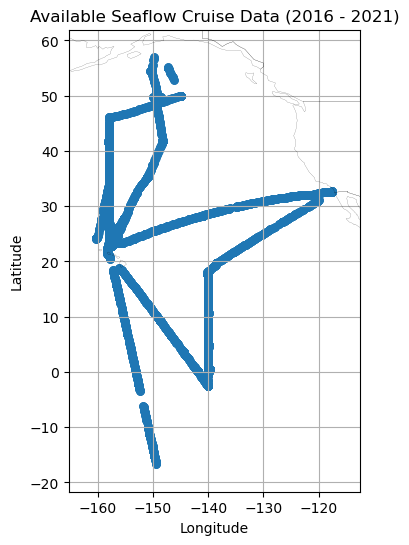

In [6]:
def cruise_tract(dataframe):
    import seaborn as sns
    import pandas as pd
    import geopandas as gpd
    from geopandas import GeoSeries, GeoDataFrame
    import contextily as cx


    # Create starting cruise tracks df that contains Nans
    cruise_tracks = dataframe[['time', 'lat', 'lon']]

    # Creating a geometry dataframe to map in geopandas
    from shapely.geometry import Point
    # Creating geometry points to plot
    geometry = [Point(xy) for xy in zip(cruise_tracks['lon'],
                                        cruise_tracks['lat'])]

    gdf = GeoDataFrame(cruise_tracks, geometry=geometry, crs=3857)

    # Load the world map shapefile using GeoPandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Create a GeoPandas plot of the world map
    fig, ax = plt.subplots(figsize=(10, 6))
    world.boundary.plot(ax=ax, linewidth=0.1, color='k')  # plot the world map boundaries
    #setting bounds of the map
    bounds = gdf.geometry.bounds

    ax.set_xlim([bounds.minx.min()-5, bounds.maxx.max()+5])
    ax.set_ylim([bounds.miny.min()-5, bounds.maxy.max()+5])


    gdf.plot(linewidth=0.05, ax=ax)
    # Set the background color of the plot to white
    ax.set_facecolor('white')
    ax.grid()

    # Set the title and labels for the plot
    ax.set_title('Available Seaflow Cruise Data (2016 - 2021)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    #cx.add_basemap(ax)

    # Show the plot
    plt.show()

cruise_tract(covari)

## To make residuals we will predict on all available data for each picophytoplankton's population

In [6]:
def predictions_and_residuals(rf, features, pop_df):
    # Filter dataframes based on PopulationName
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(features)
    
    # Add 'Prediction' and 'residuals' columns to the dataframe
    pop_df.rename(columns={'biomass': 'actual'}, inplace=True)
    pop_df['prediction'] = predictions
    pop_df['residuals'] = ((pop_df['actual'] - pop_df['prediction']) / pop_df['actual']) * 100
    
    return pop_df  



pro_df = predictions_and_residuals(rf=rf_pro, features=features_pro, pop_df=pro_df)
syn_df = predictions_and_residuals(rf=rf_syn, features=features_syn, pop_df=syn_df)
nano_df = predictions_and_residuals(rf=rf_nano, features=features_nano, pop_df=nano_df)
pico_df = predictions_and_residuals(rf=rf_pico, features=features_pico, pop_df=pico_df)


In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_actual_prediction_plots(pop_df, title_prefix='Prochlorococcus'):
    unique_cruises = pop_df['cruisename'].unique()

    # Create a subplot grid
    num_cruises = len(unique_cruises)
    rows = int(num_cruises / 2) if num_cruises % 2 == 0 else int(num_cruises / 2) + 1
    fig = make_subplots(rows=rows, cols=2, subplot_titles=unique_cruises)

    # Define colors for 'actual' and 'prediction' traces
    actual_color = 'blue'
    prediction_color = 'red'

    # Iterate over each unique cruise and add a subplot
    for i, cruise in enumerate(unique_cruises):
        # Filter dataframe for the current cruise
        cruise_df = pop_df[pop_df['cruisename'] == cruise]

        # Add the scatter plots for 'actual' and 'prediction' to the subplot
        row = int(i / 2) + 1
        col = i % 2 + 1
        fig.add_trace(go.Scatter(x=cruise_df['time'], y=cruise_df['actual'], mode='markers', name='Actual',
                                 marker=dict(color=actual_color)),
                      row=row, col=col)
        fig.add_trace(go.Scatter(x=cruise_df['time'], y=cruise_df['prediction'], mode='lines', name='Prediction',
                                 line=dict(color=prediction_color)),
                      row=row, col=col)
        fig.update_xaxes(title_text='Time', row=row, col=col)
        fig.update_yaxes(title_text='Value', row=row, col=col)

    # Update the layout and display the figure
    fig.update_layout(height=600 * rows, width=800, title_text='Actual and Prediction for Each Cruise')
    fig.show()
    
    fig.write_html(f"figures/{title_prefix}/Actual_vs_Prediction-{title_prefix}.html")


In [43]:
create_actual_prediction_plots(pop_df=pro_df, title_prefix='Prochlorococcus')
create_actual_prediction_plots(pop_df=syn_df, title_prefix='Synechococcus')
create_actual_prediction_plots(pop_df=nano_df, title_prefix='Nanoeukaryotes')
create_actual_prediction_plots(pop_df=pico_df, title_prefix='Picoeukaryotes')

In [48]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_actual_prediction_plots_sample_1day(pop_df, title_prefix='Prochlorococcus'):
    unique_cruises = pop_df['cruisename'].unique()

    # Create a subplot grid
    num_cruises = len(unique_cruises)
    rows = int(num_cruises / 2) if num_cruises % 2 == 0 else int(num_cruises / 2) + 1
    fig = make_subplots(rows=rows, cols=2, subplot_titles=unique_cruises)

    # Define colors for 'actual' and 'prediction' traces
    actual_color = 'blue'
    prediction_color = 'red'

    # Iterate over each unique cruise and add a subplot
    for i, cruise in enumerate(unique_cruises):
        # Filter dataframe for the current cruise
        cruise_df = pop_df[pop_df['cruisename'] == cruise]
        cruise_df = cruise_df.resample('1440min', on='time').mean(numeric_only=True).reset_index()


        # Add the scatter plots for 'actual' and 'prediction' to the subplot
        row = int(i / 2) + 1
        col = i % 2 + 1
        fig.add_trace(go.Scatter(x=cruise_df['time'], y=cruise_df['actual'], mode='markers', name='Actual',
                                 marker=dict(color=actual_color)),
                      row=row, col=col)
        fig.add_trace(go.Scatter(x=cruise_df['time'], y=cruise_df['prediction'], mode='lines', name='Prediction',
                                 line=dict(color=prediction_color)),
                      row=row, col=col)
        fig.update_xaxes(title_text='Time', row=row, col=col)
        fig.update_yaxes(title_text='Value', row=row, col=col)

    # Update the layout and display the figure
    fig.update_layout(height=600 * rows, width=800, title_text='Daily Averaged Actual and Prediction for Each Cruise')
    fig.show()
    
    fig.write_html(f"figures/{title_prefix}/Actual_vs_Prediction_1Day-{title_prefix}.html")


In [49]:
create_actual_prediction_plots_sample_1day(pop_df=pro_df, title_prefix='Prochlorococcus')
create_actual_prediction_plots_sample_1day(pop_df=syn_df, title_prefix='Synechococcus')
create_actual_prediction_plots_sample_1day(pop_df=nano_df, title_prefix='Nanoeukaryotes')
create_actual_prediction_plots_sample_1day(pop_df=pico_df, title_prefix='Picoeukaryotes')

In [9]:
import plotly.graph_objects as go

def create_globe_scatter_plot(pop_df, title_prefix="Prochlorococcus", start_lat=0, start_lon=0):
    # Create a 3D scatter plot on a globe
    fig = go.Figure(data=go.Scattergeo(
        lat=pop_df['lat'],
        lon=pop_df['lon'],
        mode='markers',
        marker=dict(
            size=4,
            color=pop_df['residuals'],
            colorscale='Spectral',
            cmin=-50,
            cmax=50,
            colorbar=dict(title='Residuals (%)')
        )
    ))

    # Set the projection type to 'orthographic' for a globe, fitbounds centers the plot on data
    fig.update_geos(projection_type='orthographic', fitbounds="locations")
    # Set the title
    title = f"{title_prefix} Biomass Residuals"
    fig.update_layout(title=title)

    # Show the figure
    fig.show()
    f"{title_prefix} Biomass Residuals"
    fig.write_html(f"figures/{title_prefix}/globe_heatmap-residuals_{title_prefix}.html")


In [10]:
create_globe_scatter_plot(pop_df=pro_df, title_prefix='Prochlorococcus')
create_globe_scatter_plot(pop_df=syn_df, title_prefix='Synechococcus')
create_globe_scatter_plot(pop_df=pico_df, title_prefix='Picoeukaryotes')
create_globe_scatter_plot(pop_df=nano_df, title_prefix='Nanoeukaryotes')

In [51]:
import numpy as np
import plotly.graph_objects as go

def create_globe_scatter_plot_1deg_binned(pop_df, title_prefix="Prochlorococcus", start_lat=0, start_lon=0):
    # Round latitude and longitude values to the nearest degree
    lat_bins = np.round(pop_df['lat'])
    lon_bins = np.round(pop_df['lon'])

    # Create a new DataFrame with the binned latitude and longitude values
    binned_df = pop_df.copy()
    binned_df['lat_bins'] = lat_bins
    binned_df['lon_bins'] = lon_bins

    # Group the data by latitude and longitude bins and calculate the average residuals
    grouped_df = binned_df.groupby(['lat_bins', 'lon_bins']).mean().reset_index()

    # Create a 3D scatter plot on a globe
    fig = go.Figure(data=go.Scattergeo(
        lat=grouped_df['lat_bins'],
        lon=grouped_df['lon_bins'],
        mode='markers',
        marker=dict(
            size=4,
            color=grouped_df['residuals'],
            colorscale='Spectral',
            cmin=-50,
            cmax=50,
            colorbar=dict(title='Residuals (%)')
        )
    ))

    # Set the projection type to 'orthographic' for a globe, fitbounds centers the plot on data
    fig.update_geos(projection_type='orthographic', fitbounds="locations")
    # Set the title
    title = f"{title_prefix} Biomass Residuals"
    fig.update_layout(title=title)

    # Show the figure
    fig.show()
    fig.write_html(f"figures/{title_prefix}/globe_heatmap-residuals_1deg_binned_{title_prefix}.html")


In [52]:
create_globe_scatter_plot_1deg_binned(pop_df=pro_df, title_prefix='Prochlorococcus')
create_globe_scatter_plot_1deg_binned(pop_df=syn_df, title_prefix='Synechococcus')
create_globe_scatter_plot_1deg_binned(pop_df=pico_df, title_prefix='Picoeukaryotes')
create_globe_scatter_plot_1deg_binned(pop_df=nano_df, title_prefix='Nanoeukaryotes')

/var/folders/w6/gkpzzsjx0n101092kzm2dnh00000gn/T/ipykernel_61421/1009455223.py:15: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



/var/folders/w6/gkpzzsjx0n101092kzm2dnh00000gn/T/ipykernel_61421/1009455223.py:15: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



/var/folders/w6/gkpzzsjx0n101092kzm2dnh00000gn/T/ipykernel_61421/1009455223.py:15: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



/var/folders/w6/gkpzzsjx0n101092kzm2dnh00000gn/T/ipykernel_61421/1009455223.py:15: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [19]:
feature_importance_pro

0
NH4    0.149181
PO4    0.135428
temp   0.104039
salin  0.085835
DIC    0.068136
ALK    0.060695
O2     0.060231
FeT    0.052978
POC    0.046713
PIC    0.043561
par    0.043024
CDOM   0.035641
SiO2   0.035292
NO3    0.028853
NO2    0.026417
DOC    0.023976

In [22]:
import pandas as pd
import numpy as np

def filter_top_95_variable_importance(df):
    # Step 1: Check that the sum of the "0" column is equal to 1
    total_sum = df[0].sum()
    if not np.isclose(total_sum, 1.0):
        raise ValueError("The sum of values in column '0' is not equal to 1.")
    
    # Step 2: Sort the DataFrame in descending order based on the '0' column
    sorted_df = df.sort_values(by=0, ascending=False)

    # Step 3: Select the top rows until the cumulative sum reaches 0.95
    threshold = 0.95
    cumulative_sum = 0.0
    selected_rows = []
    for index, row in sorted_df.iterrows():
        cumulative_sum += row[0]
        selected_rows.append(row)
        if cumulative_sum >= threshold:
            break

    # Create a new DataFrame with the selected rows
    selected_df = pd.DataFrame(selected_rows)

    return selected_df

              0
NH4    0.149181
PO4    0.135428
temp   0.104039
salin  0.085835
DIC    0.068136
ALK    0.060695
O2     0.060231
FeT    0.052978
POC    0.046713
PIC    0.043561
par    0.043024
CDOM   0.035641
SiO2   0.035292
NO3    0.028853
NO2    0.026417


0.9760236747764442

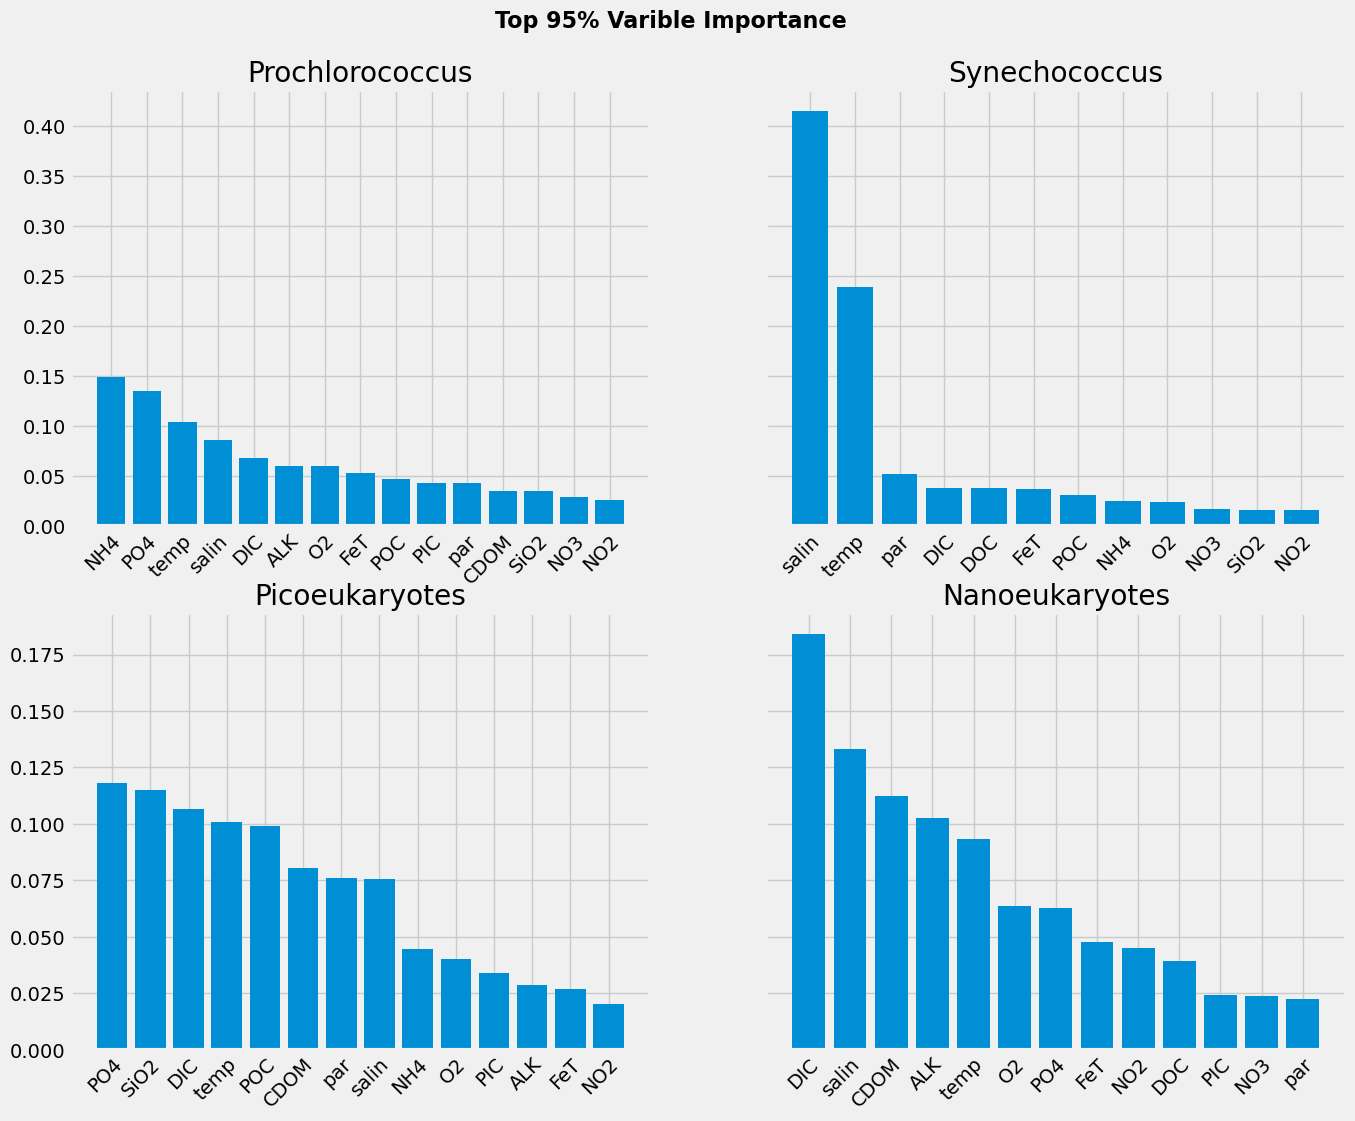

In [46]:
### Plotting variable importances (that add up to 90%) for all four populations ######

# Create four polar axes and access them through the returned array -- Shared Y Axis!
fig, axs = plt.subplots(2, 2, sharey='row', figsize=(15,8))

########################### Prochlorococcus #################################

# Gathering Feature importance
feature_importance_pro = pd.DataFrame(rf_pro.feature_importances_, index=feature_list_pro).sort_values(by=0, ascending=False)
feature_importance_pro = filter_top_95_variable_importance(feature_importance_pro)

#plotting feature importance
axs[0,0].bar(x=feature_importance_pro.index,height=feature_importance_pro[0], orientation = 'vertical')
#aligning x ticks
axs[0, 0].set_xticks(feature_importance_pro.index)
axs[0, 0].set_xticklabels(feature_importance_pro.index, rotation=45, ha='right', rotation_mode='anchor')
axs[0, 0].set_title('Prochlorococcus')

########################### Synechococcus #################################

# Gathering Feature importance
feature_importance_syn = pd.DataFrame(rf_syn.feature_importances_, index=feature_list_syn).sort_values(by=0, ascending=False)
feature_importance_syn = filter_top_95_variable_importance(feature_importance_syn)

#plotting feature importance
axs[0,1].bar(x=feature_importance_syn.index,height=feature_importance_syn[0], orientation = 'vertical')
#aligning x ticks
axs[0, 1].set_xticks(feature_importance_syn.index)
axs[0, 1].set_xticklabels(feature_importance_syn.index, rotation=45, ha='right', rotation_mode='anchor')
axs[0, 1].set_title('Synechococcus')

########################### Picoeukaryotes #################################

# Gathering Feature importance
feature_importance_pico = pd.DataFrame(rf_pico.feature_importances_, index=feature_list_pico).sort_values(by=0, ascending=False)
feature_importance_pico = filter_top_95_variable_importance(feature_importance_pico)

#plotting feature importance
axs[1,0].bar(x=feature_importance_pico.index,height=feature_importance_pico[0], orientation = 'vertical')
#aligning x ticks
axs[1, 0].set_xticks(feature_importance_pico.index)
axs[1, 0].set_xticklabels(feature_importance_pico.index, rotation=45, ha='right', rotation_mode='anchor')
axs[1, 0].set_title('Picoeukaryotes')


########################### Nanoeukaryotes #################################

# Gathering Feature importance
feature_importance_nano = pd.DataFrame(rf_nano.feature_importances_, index=feature_list_nano).sort_values(by=0, ascending=False)
feature_importance_nano = filter_top_95_variable_importance(feature_importance_nano)

#plotting feature importance
axs[1, 1].bar(x=feature_importance_nano.index,height=feature_importance_nano[0], orientation = 'vertical')
#aligning x ticks
axs[1, 1].set_xticks(feature_importance_nano.index)
axs[1, 1].set_xticklabels(feature_importance_nano.index, rotation=45, ha='right', rotation_mode='anchor')
axs[1,1].set_title('Nanoeukaryotes')



plt.suptitle("Top 95% Varible Importance", fontsize=16, fontweight='bold', y=1.4)  # y position adjusts the vertical placement of the title
plt.subplots_adjust(left=0.1, right=0.95, top=1.3, bottom=0.1)  # Adjust the padding as needed


plt.style.use('fivethirtyeight')
plt.show()



# # Import matplotlib for plotting and use magic command for Jupyter Notebooks
# import matplotlib.pyplot as plt
# %matplotlib inline
# # Set the style

# # Make a bar chart


# # Axis labels and title
# plt.ylabel('Importance'); plt.title('Variable Importances for Pro RF');

In [12]:
#!pip install plotly==5.15.0
